# Imports & Configs

In [4]:
import warnings
import os
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
import tensorflow as tf
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Data Preprocessing

In [5]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,794,1,0.5,1,0,1,2,0.8,106,6,...,1222,1890,668,13,4,19,1,1,0,0
1996,1965,1,2.6,1,0,0,39,0.2,187,4,...,915,1965,2032,11,10,16,1,1,1,2
1997,1911,0,0.9,1,1,1,36,0.7,108,8,...,868,1632,3057,9,1,5,1,1,0,3
1998,1512,0,0.9,0,4,1,46,0.1,145,5,...,336,670,869,18,10,19,1,1,1,0


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

In [7]:
df_train.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [8]:
df_train.describe()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,2000.000000,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1238.518500,0.4950,1.522250,0.509500,4.309500,0.521500,32.046500,0.501750,140.249000,4.520500,...,645.108000,1251.515500,2124.213000,12.306500,5.767000,11.011000,0.761500,0.503000,0.507000,1.500000
std,439.418206,0.5001,0.816004,0.500035,4.341444,0.499662,18.145715,0.288416,35.399655,2.287837,...,443.780811,432.199447,1084.732044,4.213245,4.356398,5.463955,0.426273,0.500116,0.500076,1.118314
min,501.000000,0.0000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,1.000000,...,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,851.750000,0.0000,0.700000,0.000000,1.000000,0.000000,16.000000,0.200000,109.000000,3.000000,...,282.750000,874.750000,1207.500000,9.000000,2.000000,6.000000,1.000000,0.000000,0.000000,0.750000
50%,1226.000000,0.0000,1.500000,1.000000,3.000000,1.000000,32.000000,0.500000,141.000000,4.000000,...,564.000000,1247.000000,2146.500000,12.000000,5.000000,11.000000,1.000000,1.000000,1.000000,1.500000
75%,1615.250000,1.0000,2.200000,1.000000,7.000000,1.000000,48.000000,0.800000,170.000000,7.000000,...,947.250000,1633.000000,3064.500000,16.000000,9.000000,16.000000,1.000000,1.000000,1.000000,2.250000
max,1998.000000,1.0000,3.000000,1.000000,19.000000,1.000000,64.000000,1.000000,200.000000,8.000000,...,1960.000000,1998.000000,3998.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.000000,3.000000


In [9]:
df_train['price_range'].unique()

array([1, 2, 3, 0])

## Missing Data

In [10]:
total = df_train.shape[0]
missing_columns = [col for col in df_train.columns if df_train[col].isnull().sum() > 0]
for col in missing_columns:
    null_count = df_train[col].isnull().sum()
    per = (null_count/total) * 100
    print(f"{col}: {null_count} ({round(per, 3)}%)")

No missing values!

## Duplicates 

In [11]:
print(f"Number of duplicate rows: {df_train.duplicated().sum()}")

Number of duplicate rows: 0


Great! No duplicates

# Scaling, Encoding and Splitting

In [14]:
x_train = df_train.drop('price_range', axis=1).values
x_test = df_test.drop('id', axis=1).values
y_train = df_train['price_range'].values

In [15]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)

In [16]:
ohe = OneHotEncoder()
y_train= ohe.fit_transform(y_train.reshape(-1, 1)).toarray()

# Modeling

In [26]:
model = tf.keras.models.Sequential([
    Dense(64, input_dim=20, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
earlyStoppingCallback = EarlyStopping(patience=50)

history = model.fit(x_train, y_train, epochs=400, batch_size=16, validation_split=0.1, callbacks=[earlyStoppingCallback])

Epoch 1/400
113/113 [==============================] - 1s 3ms/step - loss: 1.4948 - accuracy: 0.2711 - val_loss: 1.3384 - val_accuracy: 0.4400
Epoch 2/400
113/113 [==============================] - 0s 2ms/step - loss: 1.3588 - accuracy: 0.3206 - val_loss: 1.2237 - val_accuracy: 0.5150
Epoch 3/400
113/113 [==============================] - 0s 2ms/step - loss: 1.2005 - accuracy: 0.4333 - val_loss: 0.9249 - val_accuracy: 0.5950
Epoch 4/400
113/113 [==============================] - 0s 1ms/step - loss: 1.0200 - accuracy: 0.5000 - val_loss: 0.7230 - val_accuracy: 0.6950
Epoch 5/400
113/113 [==============================] - 0s 2ms/step - loss: 0.8836 - accuracy: 0.5594 - val_loss: 0.6176 - val_accuracy: 0.7050
Epoch 6/400
113/113 [==============================] - 0s 2ms/step - loss: 0.8104 - accuracy: 0.6039 - val_loss: 0.5501 - val_accuracy: 0.7900
Epoch 7/400
113/113 [==============================] - 0s 2ms/step - loss: 0.7122 - accuracy: 0.6694 - val_loss: 0.5098 - val_accuracy: 0.7800

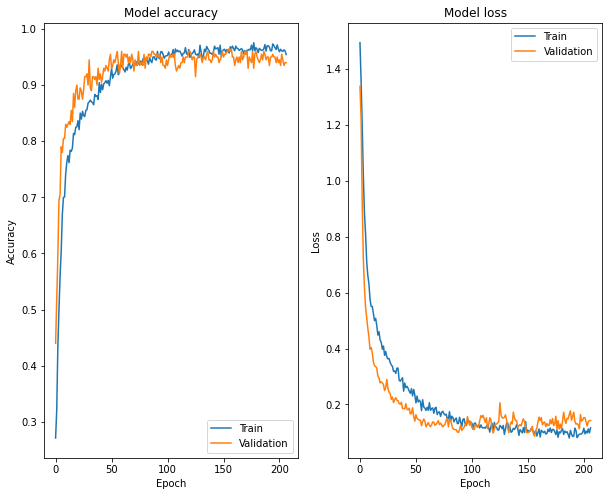

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(10, 8))

# Accuracy
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('Model accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Validation'])

# Loss
axs[1].plot(history.history['loss']) 
axs[1].plot(history.history['val_loss']) 
axs[1].set_title('Model loss') 
axs[1].set_ylabel('Loss') 
axs[1].set_xlabel('Epoch') 
axs[1].legend(['Train', 'Validation']) 

plt.show()

# Predictions

In [29]:
y_predict = model.predict(x_test)

32/32 [==============================] - 0s 773us/step


In [30]:
predictions = []

for i in range(len(y_predict)):
    predictions.append(np.argmax(y_predict[i]))

predictions[0:10]

[2, 3, 2, 3, 1, 3, 3, 1, 3, 0]